In [5]:
import jax.numpy as jnp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_default_device", jax.devices()[2])

import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import OperatorModel,SplitOperatorPDEModel,OperatorPDEModel,build_batched_jac_func
from evaluation_metrics import compute_results    
from data_utils import MinMaxScaler
from evaluation_metrics import get_nrmse

from Kernels import log1pexp,inv_log1pexp, get_gaussianRBF
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params
)
from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel
from functools import partial

from Optimizers.full_jacobian import CholeskyLM, SVD_LM
from Optimizers.solvers_base import *

# import Optimizers
# import importlib
# importlib.reload(Optimizers)
# from Optimizers import CholeskyLM,SVD_LM,SketchedLM

import time
from jax.scipy.sparse.linalg import cg
from jax.scipy.linalg import solve,cho_factor,cho_solve

# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from scipy.spatial import distance
from matplotlib import cm
import time
from mpl_toolkits.mplot3d import Axes3D
# from pyDOE import lhs
# #    import sobol_seq
import os
from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data,
    GP_Sampler_1D_Pinned
)
from plotting import plot_input_data,plot_compare_error
from evaluation_metrics import compute_results
plt.style.use("default")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 12
})

In [42]:
def get_burgers_data(gamma,n_obs, n_coll_t, n_coll_x,run):
    kernel_GP = get_gaussianRBF(0.2)
    xy_pts = jnp.linspace(0,1,50) # Pts to build interpolants
    u0_true_function = GP_Sampler_1D_Pinned(num_samples = 1,
                                            X = xy_pts, 
                                            smooth = gamma,
                                            kernel = kernel_GP,
                                            reg = 1e-8,
                                            seed = run
                                        )
    vec_u0_true_function = np.vectorize(u0_true_function[0])
                            
    # Solve Burgers' equations with IC u_0_true_function
    kappa = 0.01
    alpha = 1.
    u_true_function,ut_true_function, interp,_,_ = (
    build_burgers_data(func_u0=vec_u0_true_function,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
                        )
    # Plot
    num_fine = 500
    plt.title("True initial and final")
    grid_points = jnp.linspace(0,1,num_fine)
    plt.plot(grid_points,u_true_function(jnp.vstack([0.0*jnp.ones(num_fine),grid_points]).T),label = 't=0')
    plt.plot(grid_points,u_true_function(jnp.vstack([1.*jnp.ones(num_fine),grid_points]).T),label = 't=1')
    plt.legend()
    plt.show()

    # Collocation point set size
    num_grid_x = n_coll_x
    num_grid_t = n_coll_t
    tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.5)

    # Collocation point set

    # Get (X^m, u^m(X^m))
    num_obs = n_obs
    tx_all,tx_obs = setup_problem_data(
        tx_int,
        tx_bdy,
        num_obs,
        jax.random.PRNGKey(run),
        times_to_observe = (0,)
    )

    u_obs = u_true_function(tx_obs)
    t_fine,x_fine = jnp.meshgrid(jnp.linspace(0,1,300),jnp.linspace(0,1,300))
    tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
    plot_input_data(
        tx_obs,
        tx_all,
        u_true_function,
        tx_fine,
                )

    return tx_obs, u_obs, tx_all, tx_int, tx_fine, u_true_function, ut_true_function, interp

  0%|          | 0/10099 [00:00<?, ?it/s]

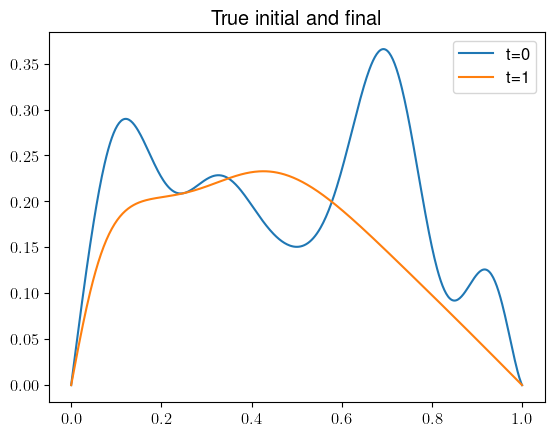

(Array([[0.        , 0.        ],
        [0.04      , 0.        ],
        [0.08      , 0.        ],
        [0.12      , 0.        ],
        [0.16      , 0.        ],
        [0.2       , 0.        ],
        [0.24      , 0.        ],
        [0.28      , 0.        ],
        [0.32      , 0.        ],
        [0.36      , 0.        ],
        [0.4       , 0.        ],
        [0.44      , 0.        ],
        [0.48      , 0.        ],
        [0.52      , 0.        ],
        [0.56      , 0.        ],
        [0.6       , 0.        ],
        [0.64      , 0.        ],
        [0.68      , 0.        ],
        [0.72      , 0.        ],
        [0.76      , 0.        ],
        [0.8       , 0.        ],
        [0.84      , 0.        ],
        [0.88      , 0.        ],
        [0.92      , 0.        ],
        [0.96      , 0.        ],
        [1.        , 0.        ],
        [0.        , 1.        ],
        [0.04      , 1.        ],
        [0.08      , 1.        ],
        [0.12 

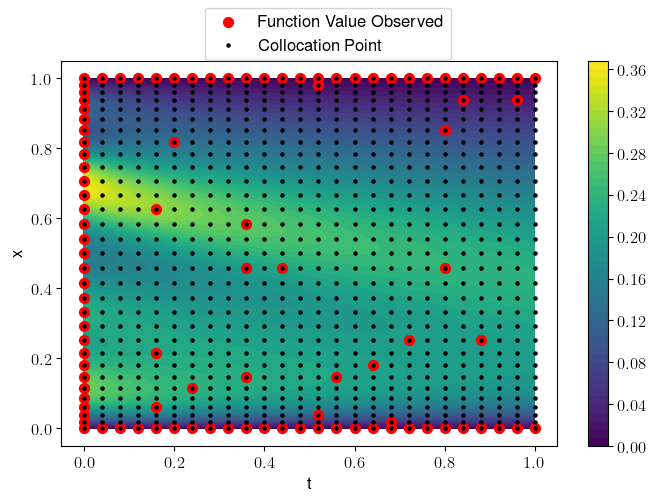

In [43]:
get_burgers_data(gamma=2,n_obs=20, n_coll_t=26, n_coll_x=31,run=0)

In [7]:
def sparsifyDynamics(Theta,dXdt,lamb,n):
    # Initial guess: Least-squares
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0]

    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coeffs.
        Xi[smallinds]=0 # and threshold
        for ind in range(n): # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,
                biginds],dXdt[:,ind],rcond=None)[0]
        return Xi

## In-sample errors

### 1.5 step method

In [95]:
def get_1_5_error(n_obs,run):
    tx_obs, u_obs, tx_all, tx_int, tx_fine, u_true_function, ut_true_function, interp = get_burgers_data(gamma=2,n_obs=n_obs,n_coll_t=26, n_coll_x=31, run=run)
    # Run 1_5 step method
    # u_operators = (eval_k,)
    u_operators = (eval_k,dx_k,dt_k)
    feature_operators = (eval_k,dx_k,dxx_k)

    # Choose u kernel
    def param_ani_gaussian_RBF(x,y,params):
        lengthscales = log1pexp(params)
        return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

    fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
    ML_lengthscales = log1pexp(fitted_params)
    print(1/(jnp.sqrt(ML_lengthscales)))
    k_u = get_anisotropic_gaussianRBF(0.75,jnp.diag(log1pexp(fitted_params)))

    # RKHS class for u
    u_model = CholInducedRKHS(
        tx_all,
        u_operators,
        k_u,
        nugget_size = 1e-8
        )
    u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

    grid_features_init = (
        (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
        .reshape(
                len(tx_int),
                len(feature_operators),
                order = 'F'
            )
    )

    # Choose kernel for P
    k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')
    @vectorize_kfunc
    def k_P(x,y):
        return k_P_u_part(x[2:],y[2:])
    P_model = OperatorModel(k_P)

    # Equation model that has u and P object
    EqnModel = OperatorPDEModel(
        P_model,
        (u_model,),
        (tx_obs,),
        (u_obs,),
        (tx_int,),
        feature_operators,
        rhs_operator=dt_k,
        datafit_weight = 100
    )
    params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])
    optparams = LMParams(max_iter = 201)

    params,convergence_data = CholeskyLM(
        params_init.copy(),
        EqnModel,
        beta = 1e-11,
        optParams = optparams
    )

    u_sol = params[:u_model.num_params]
    P_sol = params[u_model.num_params:]

    # u_true 
    u_true = u_true_function(tx_fine)
    # get error
    error_u = get_nrmse(u_true, u_model.point_evaluate(tx_fine,u_sol))
    
    num_fine_grid = 100
    t_fine,x_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
    tx_fine_int = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

    # Estimated P from 1.5 step method
    input_features = EqnModel.get_stacked_eqn_features((u_sol,)) # before
    # input_features = EqnModel.single_eqn_features(u_model,u_sol,tx_all) # now
    Phat = lambda x: P_model.predict_new(x,input_features,P_sol)

    # In-sample
    
    # P[\phi(w)](fine_grid)
    def evaluate_Phat(Phat, interp, fine_grid):

        # Build S_test
        def u_true_function(x):
            return interp(x[:,0],x[:,1],grid = False)
        def ux_true_function(x):
            ux_interp = interp.partial_derivative(0,1)
            return ux_interp(x[:,0],x[:,1],grid = False)
        def uxx_true_function(x):
            uxx_interp = interp.partial_derivative(0,2)
            return uxx_interp(x[:,0],x[:,1],grid = False)
        
        # By hand since the truth is taken as interp from scipy and not an induced RKHS class where we can apply usual feature operators
        feat_funcs = [u_true_function, ux_true_function, uxx_true_function]
        w_features = jnp.array([feat_func(fine_grid) for feat_func in feat_funcs]).T
        fine_features = jnp.hstack([fine_grid, w_features])
        S_test = fine_features
        
        P_preds = Phat(S_test)
        return P_preds

    Phat_u = evaluate_Phat(Phat, interp, tx_fine_int)
    u_t = ut_true_function(tx_fine_int)

    error_Phat = get_nrmse(u_t, Phat_u)

    return error_u, error_Phat

In [96]:
e_ismpl_1_5 = {'u': [], 'Phat':[]}

In [ ]:
for n_obs in [10,20,30,40,50,60,70,80,90]:
    u_errs = []
    P_errs = []
    for run in range(5):
        res = get_1_5_error(n_obs,run)
        u_errs.append(res[0])
        P_errs.append(res[1])
    e_ismpl_1_5['u'].append(u_errs)
    e_ismpl_1_5['Phat'].append(P_errs)
    # Save after
    jnp.save('e_ismpl_1_5', e_ismpl_1_5)

### SINDy

In [31]:
def get_SINDy_error(n_obs,run):
    tx_obs, u_obs, tx_all, tx_int, tx_fine, u_true_function, ut_true_function, interp = get_burgers_data(gamma=2,n_obs=n_obs,n_coll_t=26, n_coll_x=31, run=run)
    # Run 1_5 step method
    # u_operators = (eval_k,)
    u_operators = (eval_k,)
    feature_operators = (eval_k,dt_k,dx_k,dxx_k)
    
    # Choose u kernel
    def param_ani_gaussian_RBF(x,y,params):
        lengthscales = log1pexp(params)
        return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

    fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
    ML_lengthscales = log1pexp(fitted_params)
    print(1/(jnp.sqrt(ML_lengthscales)))
    k_u = get_anisotropic_gaussianRBF(0.75,jnp.diag(log1pexp(fitted_params)))

    # RKHS class for u
    u_model = CholInducedRKHS(
        tx_all,
        u_operators,
        k_u,
        nugget_size = 1e-8
        )
    u_params = u_model.get_fitted_params(tx_obs,u_obs)

    # Get necessary tuples
    u_sol = u_model.get_fitted_params(tx_obs,u_obs)

    S = (u_model.evaluate_operators(feature_operators,tx_int,u_params).reshape(
                len(tx_int), 
                len(feature_operators),
                order = 'F'
                    ))
    
    CONST = jnp.ones(len(S[:,0]))
    U = S[:,0]
    U_t = S[:,1]
    U_x = S[:,2]
    U_xx = S[:,3]
    UU = jnp.multiply(S[:,0],S[:,0])
    UU_x = jnp.multiply(S[:,0],S[:,2])
    UU_xx = jnp.multiply(S[:,0],S[:,3])
    U_xU_x = jnp.multiply(S[:,2],S[:,2])
    U_xU_xx = jnp.multiply(S[:,2],S[:,3])
    U_xxU_xx = jnp.multiply(S[:,3],S[:,3])
    
    

    Theta = jnp.vstack([CONST,U,U_x,U_xx,
                        UU,UU_x,UU_xx,U_xU_x,
                        U_xU_xx,U_xxU_xx]).T


    res_SINDy = sparsifyDynamics(Theta,U_t.reshape(-1,1),lamb = 1e-8, n = 1)

    # u_true 
    u_true = u_true_function(tx_fine)
    # get error
    error_u = get_nrmse(u_true, u_model.point_evaluate(tx_fine,u_sol))
    
    num_fine_grid = 100
    t_fine,x_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
    tx_fine_int = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

    
    def Phat(s,coeffs):
        return jnp.dot(s,coeffs)

    # In-sample
        
    # P[\phi(w)](fine_grid)
    def evaluate_Phat(Phat, interp, fine_grid):

        # Build S_test
        def one_func(x):
            return jnp.ones(len(x))
        def u_true_function(x):
            return interp(x[:,0],x[:,1],grid = False)
        def ux_true_function(x):
            ux_interp = interp.partial_derivative(0,1)
            return ux_interp(x[:,0],x[:,1],grid = False)
        def uxx_true_function(x):
            uxx_interp = interp.partial_derivative(0,2)
            return uxx_interp(x[:,0],x[:,1],grid = False)
        def uu_true_function(x):
            return u_true_function(x)**2
        def uux_true_function(x):
            return u_true_function(x)*ux_true_function(x)
        def uuxx_true_function(x):
            return u_true_function(x)*uxx_true_function(x)
        def uxux_true_function(x):
            return ux_true_function(x)*ux_true_function(x)
        def uxuxx_true_function(x):
            return ux_true_function(x)*uxx_true_function(x)
        def uxxuxx_true_function(x):
            return uxx_true_function(x)*uxx_true_function(x)
    
        
        # By hand since the truth is taken as interp from scipy and not an induced RKHS class where we can apply usual feature operators
        feat_funcs = [one_func,u_true_function, ux_true_function, uxx_true_function,
                      uu_true_function,uux_true_function,uuxx_true_function,
                      uxux_true_function,uxuxx_true_function,uxxuxx_true_function]
        fine_features = jnp.array([feat_func(fine_grid) for feat_func in feat_funcs]).T
        S_test = fine_features
        
        P_preds = Phat(S_test,res_SINDy)
        return P_preds

    Phat_u = evaluate_Phat(Phat, interp, tx_fine_int)
    u_t = ut_true_function(tx_fine_int)

    error_Phat = get_nrmse(u_t, Phat_u.flatten())

    return error_u, error_Phat

In [36]:
e_ismpl_SINDy = {'u': [], 'P':[]}

In [ ]:
for n_obs in [10,20,30,40,50,60,70,80,90]:
    u_errs = []
    P_errs = []
    for run in range(5):
        res = get_SINDy_error(n_obs,run)
        u_errs.append(res[0])
        P_errs.append(res[1])
    e_ismpl_SINDy['u'].append(u_errs)
    e_ismpl_SINDy['P'].append(P_errs)

In [38]:
u_s = jnp.array([jnp.mean(jnp.array(el)) for el in e_ismpl_SINDy['u']])
u_stds = jnp.array([jnp.std(jnp.array(el)) for el in e_ismpl_SINDy['u']])
P_s = jnp.array([jnp.mean(jnp.array(el)) for el in e_ismpl_SINDy['P']])
P_stds = jnp.array([jnp.std(jnp.array(el)) for el in e_ismpl_SINDy['P']])

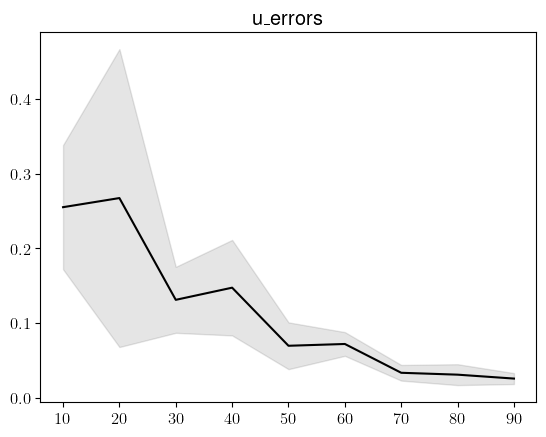

In [39]:
plt.title('u_errors')
plt.plot(jnp.arange(10,100,10),u_s, color = 'black')
plt.fill_between(jnp.arange(10,100,10), u_s - u_stds, u_s + u_stds, alpha=.1, color = 'black')

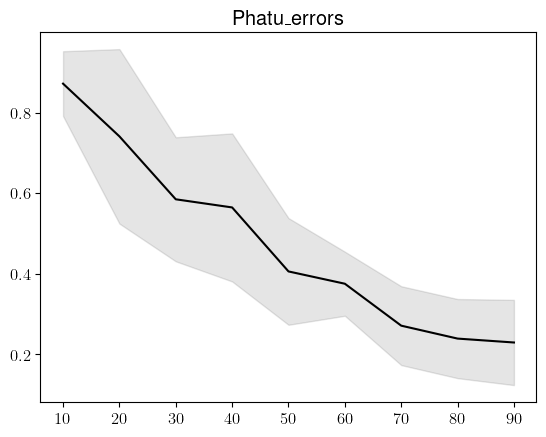

In [40]:
plt.title('Phatu_errors')
plt.plot(jnp.arange(10,100,10),P_s,color = 'black')
plt.fill_between(jnp.arange(10,100,10), P_s - P_stds, P_s + P_stds, alpha=.1, color = 'black')

### PINNSR

In [49]:
def get_data_for_pinns(gamma,n_obs, n_coll_t, n_coll_x,run):
    kernel_GP = get_gaussianRBF(0.2)
    xy_pts = jnp.linspace(0,1,50) # Pts to build interpolants
    u0_true_function = GP_Sampler_1D_Pinned(num_samples = 1,
                                            X = xy_pts, 
                                            smooth = gamma,
                                            kernel = kernel_GP,
                                            reg = 1e-8,
                                            seed = run
                                        )
    vec_u0_true_function = np.vectorize(u0_true_function[0])
    
    # Solve Burgers' equations with IC u_0_true_function
    kappa = 0.01
    alpha = 1.
    u_true_function,ut_true_function, interp,_,_ = (
    build_burgers_data(func_u0=vec_u0_true_function,kappa = kappa,alpha = alpha, k_timestep=0.0001,n_finite_diff=1999)
                        )
    
    # # Plot
    # num_fine = 500
    # plt.title("True initial and final")
    # grid_points = jnp.linspace(0,1,num_fine)
    # plt.plot(grid_points,u_true_function(jnp.vstack([0.0*jnp.ones(num_fine),grid_points]).T),label = 't=0')
    # plt.plot(grid_points,u_true_function(jnp.vstack([1.*jnp.ones(num_fine),grid_points]).T),label = 't=1')
    # plt.legend()
    # plt.show()

    # Collocation point set
    num_grid_x = n_coll_x
    num_grid_t = n_coll_t
    tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.5)

    # Get (X^m, u^m(X^m))
    num_obs = n_obs
    tx_all,tx_obs = setup_problem_data(
        tx_int,
        tx_bdy,
        num_obs,
        jax.random.PRNGKey(run),
        times_to_observe = (0,)
    )

    u_obs = u_true_function(tx_obs)
    t_fine,x_fine = jnp.meshgrid(jnp.linspace(0,1,300),jnp.linspace(0,1,300))
    tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
    
    # Invert them to be ready for PINNSR 
    tx_train = tx_obs
    u_train = u_true_function(tx_train)
    tx_val = jax.random.choice(key = jax.random.PRNGKey(0), a = tx_fine, shape = (int(jnp.ceil(tx_train.shape[0]*(1-0.8)/0.8)),), replace=False)
    # plt.scatter(*tx_val.T,c = 'green')
    u_val = u_true_function(tx_val)
    lb = tx_fine.min(0)
    ub = tx_fine.max(0)

    # plot_input_data(
    #     tx_train, 
    #     tx_all,
    #     u_true_function,
    #     tx_fine,
    #             )

    tx_train = tx_train.at[:,[1,0]].set(tx_train[:,[0,1]])

    tx_val = tx_val.at[:,[1,0]].set(tx_val[:,[0,1]])

    tx_all = tx_all.at[:,[1,0]].set(tx_all[:,[0,1]])

    tx_all = jnp.vstack([tx_all,tx_train])

    

    return [tx_train, u_train, tx_all, tx_val, u_val, lb, ub]

In [50]:
data_input_pinns = get_data_for_pinns(gamma=2,n_obs=20, n_coll_t=26, n_coll_x=31,run=0)

  0%|          | 0/10099 [00:00<?, ?it/s]

In [51]:
data_input_pinns = list(map(np.array,data_input_pinns))

# Generate data

In [ ]:
data_input = []
# Run loop
NUM_RUNS = 5
N_OBS = [int(i) for i in jnp.arange(10,100,10)]
for n_obs in N_OBS:
    for run in range(NUM_RUNS):
        element = []
        element.append(n_obs)
        element.append(run)
        # Run
        data_list = get_data_for_pinns(gamma=2,n_obs=20, n_coll_t=26, n_coll_x=31,run=0)
        data_input_pinns = list(map(np.array,data_input_pinns))
        element.append(data_list)
        data_input.append(element)
np.save('data_input.npy', np.array(data_input, dtype=object), allow_pickle=True)

In [53]:
data_for_pinn =  np.load('data_input.npy', allow_pickle=True)

In [55]:
A = [e[2] for e in data_for_pinn if e[0]==40 and e[1]==2][0]

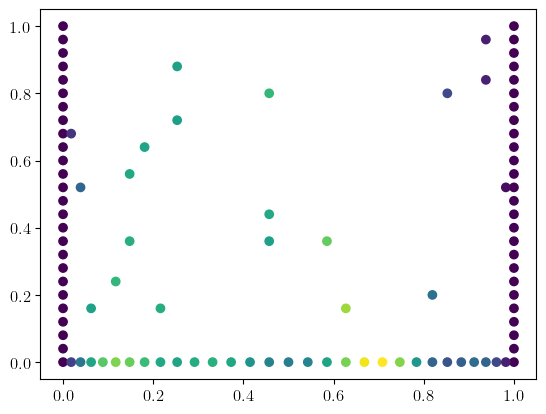

In [59]:
plt.scatter(*A[0].T, c = A[1])

The equation recovered by PINNSR was:
```
u_t = -0.0136393011
-0.33108413u
+0.0043411828u**2
-0.039289325u_x
+0.33696544u*u_x
+0.026660636u**2*u_x
+0.005249514u_xx
-0.00819559u*u_xx
-0.08392856u**2*u_xx
```

In [285]:
# Estimated P
def u_true_function(x):
    return interp(x[:,0],x[:,1],grid = False)
def ux_true_function(x):
    ux_interp = interp.partial_derivative(0,1)
    return ux_interp(x[:,0],x[:,1],grid = False)
def uxx_true_function(x):
    uxx_interp = interp.partial_derivative(0,2)
    return uxx_interp(x[:,0],x[:,1],grid = False)

fine_grid = tx_fine_int
U = u_true_function(fine_grid)
U_x = ux_true_function(fine_grid)
U_xx = uxx_true_function(fine_grid)

Phat_PINNSR = -0.0136393011-0.33108413*U+0.0043411828*jnp.multiply(U,U)-0.039289325*U_x+0.33696544*jnp.multiply(U,U_x)+0.026660636*jnp.multiply(jnp.multiply(U,U),U_x)+0.005249514*U_xx-0.00819559*jnp.multiply(U,U_xx)-0.08392856*jnp.multiply(jnp.multiply(U,U),U_xx)

Relative error:  0.38154099944734315


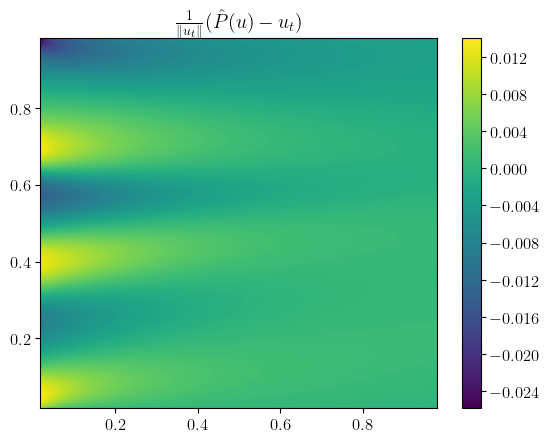

In [286]:
plt.tricontourf(*tx_fine_int.T, (Phat_PINNSR - u_t)/ jnp.linalg.norm(u_t),200)
plt.title(r'$\frac{1}{\|u_t\|}(\hat{P}(u)-u_t)$')
# plt.tricontourf(*tx_test.T, (Phat_PINNSR - u_t),200)
plt.colorbar()
print('Relative error: ',jnp.linalg.norm(Phat_PINNSR - u_t,2) / jnp.linalg.norm(u_t,2))
# plt.title(r'$\hat{P}(u)-u_t$')
plt.show()